In [3]:
%cd /content/drive/MyDrive/odev_2

/content/drive/MyDrive/odev_2


In [4]:
%ls

data/                     inception_cfs.npy      odev_2.ipynb
dataset_operations.ipynb  k_fold_training.ipynb  __pycache__/
figures/                  models/                resnet_cfs.npy
hold_out_training.ipynb   mycnn_cfs.npy          scores/


In [5]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import adam_v2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Verinin Yüklenmesi

In [5]:
X = np.load('data/X.npy')
y = np.load('data/Y.npy')
X_flatten = np.load('data/X_flatten.npy')

# ROC Eğrisi Fonksiyonu

In [7]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle

def create_roc_curve(y_test_encoded, y_pred_encoded, name, fold_number):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test_encoded[0])):
        fpr[i], tpr[i], _ = roc_curve(
            y_test_encoded[:, i], y_pred_encoded[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(
        y_test_encoded.ravel(), y_pred_encoded.ravel())

    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate(
        [fpr[i] for i in range(len(y_test_encoded[0]))]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(y_test_encoded[0])):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= len(y_test_encoded[0])
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], fpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
             ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(len(y_test_encoded[0])), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig('figures/k_fold/roc_curve_'+name+'_fold_'+str(fold_number)+'.png')
    plt.cla()
    plt.clf()

# Modellerin Tanımlanması

## Resnet

In [7]:
def createModelResNet50V2():
    img_size = 256
    img_depth = 3
    model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                              input_shape=(
                                                  img_size, img_size, img_depth),
                                              weights='imagenet')
    for layer in model.layers:
        layer.trainable = True

    x = model.output

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    prediction = tf.keras.layers.Dense(
        4, activation='softmax', name='visualized_layer')(x)

    final_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=prediction)
    opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
    final_model.compile(
        optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return final_model

## InceptionV3

In [8]:
def createModelInceptionV3():

    img_size = 256
    img_depth = 3
    model = tf.keras.applications.InceptionV3(include_top=False,
                                              input_shape=(
                                                  img_size, img_size, img_depth),
                                              weights='imagenet')
    for layer in model.layers:
        layer.trainable = True

    x = model.output

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(500, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(50, activation='relu')(x)

    prediction = tf.keras.layers.Dense(
        4, activation='softmax', name='visualized_layer')(x)

    final_model = tf.keras.models.Model(inputs=model.input,
                                        outputs=prediction)

    final_model.compile(
        optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return final_model


## Kendi CNN Mimarim

In [9]:
def createModelMyCNN():

    img_size = 256
    img_depth = 3

    model = Sequential()

    model.add(Conv2D(filters=8, kernel_size=(7, 7), padding='same',
                    activation='relu', input_shape=(img_size, img_size, img_depth)))
    model.add(Conv2D(filters=8, kernel_size=(7, 7),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(filters=16, kernel_size=(5, 5),
                    padding='same', activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(5, 5),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                    padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(
        3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(
        3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    optimizer = adam_v2.Adam(lr=0.0001, decay=1e-5)
    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer, metrics=['accuracy'])

    return model

# Inception V3 İçin 5 Foldda Eğitim

Epoch 1/2
41/41 [==============================] - 126s 3s/step - loss: 0.6569 - accuracy: 0.7457 - val_loss: 2.2899 - val_accuracy: 0.2404
Epoch 2/2
41/41 [==============================] - 112s 3s/step - loss: 0.3071 - accuracy: 0.8989 - val_loss: 2.6584 - val_accuracy: 0.4778
Epoch 1/2
41/41 [==============================] - 111s 3s/step - loss: 0.2043 - accuracy: 0.9345 - val_loss: 0.7533 - val_accuracy: 0.8515
Epoch 2/2
41/41 [==============================] - 62s 2s/step - loss: 0.1401 - accuracy: 0.9560 - val_loss: 0.8287 - val_accuracy: 0.8254
Epoch 1/2
41/41 [==============================] - 113s 3s/step - loss: 0.1633 - accuracy: 0.9464 - val_loss: 2.0150 - val_accuracy: 0.5651
Epoch 2/2
41/41 [==============================] - 111s 3s/step - loss: 0.1050 - accuracy: 0.9667 - val_loss: 0.7293 - val_accuracy: 0.8132
Epoch 1/2
41/41 [==============================] - 110s 3s/step - loss: 0.1325 - accuracy: 0.9556 - val_loss: 2.3391 - val_accuracy: 0.6708
Epoch 2/2
41/41 [====

<Figure size 1440x360 with 0 Axes>

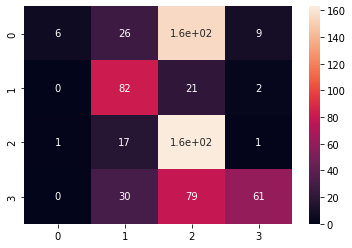

<Figure size 1440x360 with 0 Axes>

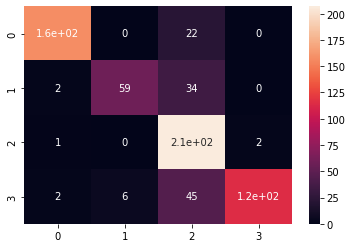

<Figure size 1440x360 with 0 Axes>

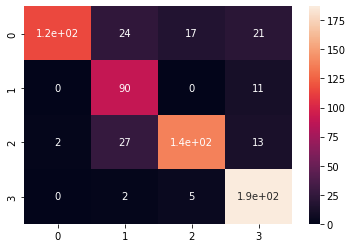

<Figure size 1440x360 with 0 Axes>

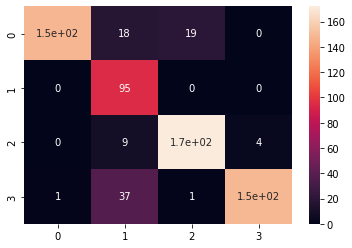

<Figure size 1440x360 with 0 Axes>

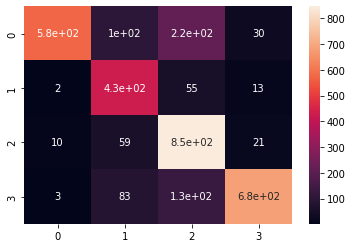

In [19]:
from sklearn.model_selection import KFold
model_path = 'models/k_fold/inceptionv3/'
cfs_inception = []
X = np.load('data/X.npy')
y = np.load('data/Y.npy')
X_flatten = np.load('data/X_flatten.npy')

kfold = KFold(n_splits=5, random_state=1, shuffle=True)
kfold.get_n_splits(X)
model_inception = createModelInceptionV3()
inception_scores = []
i = 1
for train_index, test_index in kfold.split(X):
    
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path + 'checkpoints',
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

  history = model_inception.fit(X_train, y_train,
                      epochs=2,
                      callbacks=[model_checkpoint_callback],
                      batch_size=64,
                      validation_data=(X_test, y_test),
                      verbose=1)

  plt.figure(figsize=(20, 5))

  plt.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch,
                y=history.history['loss'], color='red', label='Loss')
  sns.lineplot(x=history.epoch,
                y=history.history['val_loss'], color='orange', label='Val Loss')
  plt.title('Loss on train vs test')
  plt.legend(loc='best')

  plt.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch,
                y=history.history['accuracy'], color='blue', label='Accuracy')
  sns.lineplot(x=history.epoch,
                y=history.history['val_accuracy'], color='green', label='Val Accuracy')
  plt.title('Accuracy on train vs test')
  plt.legend(loc='best')

  plt.savefig('figures/k_fold/inception_acc_loss_graph_fold_'+str(i)+'.png')
  plt.clf()

  y_pred = model_inception.predict(X_test)

  create_roc_curve(y_test, y_pred, "inception", i)

  y_test = np.argmax(y_test, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  conf_matr = confusion_matrix(y_test, y_pred)

  FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
  FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
  TP = np.diag(conf_matr)
  TN = conf_matr.sum() - (FP + FN + TP)

  acc = (TP + TN) / (TP + FP + FN + TN)
  sen = TP / (TP + FN)
  pre = TP / (TP + FP)
  spe = TN / (TN + FP)
  f1 = (2 * (pre * sen)) / (pre + sen)

  inception_scores.append([(i), np.mean(acc), np.mean(sen),
                                         np.mean(pre), np.mean(f1), np.mean(spe)])
  plt.clf()
  cfs_inception.append(conf_matr)
  sns.heatmap(conf_matr, annot=True)
  plt.savefig('figures/k_fold/inception_conf_matrix_graph_'+str(i)+'.png')
  i+=1

plt.clf()

np.save('inception_cfs.npy', np.array(cfs_inception))
overlapped_matrix_inception = np.array(cfs_inception).sum(axis=0)
sns.heatmap(overlapped_matrix_inception, annot=True)
plt.savefig('figures/k_fold/inception_overlapped_matrix_graph.png')
df_inception = pd.DataFrame(inception_scores, columns=['fold_number', 'acc', 'sen', 'pre', 'f1', 'spe'])

df_inception.to_csv('scores/k_fold/inception_scores.csv')
model_inception.save(model_path + 'model.h5')

# Resnet50 V2 için 5 Foldda Eğitim

94683136/94668760 [==============================] - 1s 0us/step
Epoch 1/2
41/41 [==============================] - 119s 3s/step - loss: 1.3439 - accuracy: 0.3945 - val_loss: 11240641396736.0000 - val_accuracy: 0.2787
Epoch 2/2
41/41 [==============================] - 65s 2s/step - loss: 1.0688 - accuracy: 0.5373 - val_loss: 537818.4375 - val_accuracy: 0.2787


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


Epoch 1/2
41/41 [==============================] - 97s 2s/step - loss: 0.9422 - accuracy: 0.6151 - val_loss: 19563.3047 - val_accuracy: 0.1455
Epoch 2/2
41/41 [==============================] - 65s 2s/step - loss: 0.8387 - accuracy: 0.6545 - val_loss: 1457.5532 - val_accuracy: 0.1455


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


Epoch 1/2
41/41 [==============================] - 97s 2s/step - loss: 0.7557 - accuracy: 0.6867 - val_loss: 20.6640 - val_accuracy: 0.1623
Epoch 2/2
41/41 [==============================] - 65s 2s/step - loss: 0.6881 - accuracy: 0.7154 - val_loss: 7.1517 - val_accuracy: 0.1531


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide


Epoch 1/2
41/41 [==============================] - 97s 2s/step - loss: 0.6146 - accuracy: 0.7645 - val_loss: 31.3503 - val_accuracy: 0.2864
Epoch 2/2
41/41 [==============================] - 65s 2s/step - loss: 0.5667 - accuracy: 0.7775 - val_loss: 2.2197 - val_accuracy: 0.2802
Epoch 1/2
41/41 [==============================] - 103s 3s/step - loss: 0.4795 - accuracy: 0.8174 - val_loss: 1.2270 - val_accuracy: 0.5537
Epoch 2/2
41/41 [==============================] - 99s 2s/step - loss: 0.4388 - accuracy: 0.8300 - val_loss: 0.8520 - val_accuracy: 0.6718


<Figure size 1440x360 with 0 Axes>

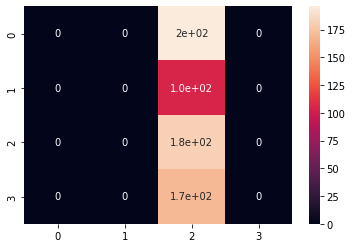

<Figure size 1440x360 with 0 Axes>

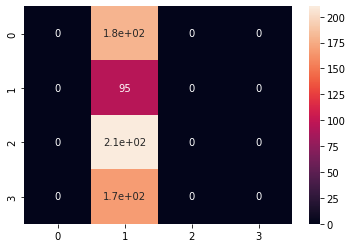

<Figure size 1440x360 with 0 Axes>

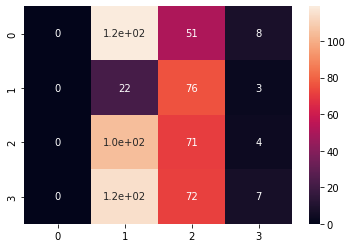

<Figure size 1440x360 with 0 Axes>

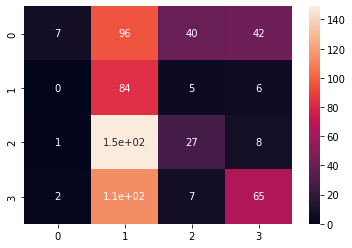

<Figure size 1440x360 with 0 Axes>

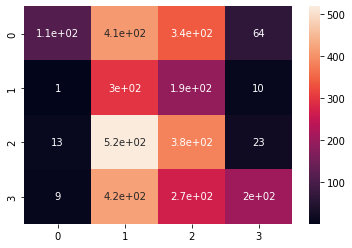

In [20]:
from sklearn.model_selection import KFold
model_path = 'models/k_fold/resnet/'
cfs_inception = []
X = np.load('data/X.npy')
y = np.load('data/Y.npy')
X_flatten = np.load('data/X_flatten.npy')

kfold = KFold(n_splits=5, random_state=1, shuffle=True)
kfold.get_n_splits(X)
model_inception = createModelResNet50V2()
inception_scores = []
i = 1
for train_index, test_index in kfold.split(X):
    
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path + 'checkpoints',
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

  history = model_inception.fit(X_train, y_train,
                      epochs=2,
                      callbacks=[model_checkpoint_callback],
                      batch_size=64,
                      validation_data=(X_test, y_test),
                      verbose=1)

  plt.figure(figsize=(20, 5))

  plt.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch,
                y=history.history['loss'], color='red', label='Loss')
  sns.lineplot(x=history.epoch,
                y=history.history['val_loss'], color='orange', label='Val Loss')
  plt.title('Loss on train vs test')
  plt.legend(loc='best')

  plt.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch,
                y=history.history['accuracy'], color='blue', label='Accuracy')
  sns.lineplot(x=history.epoch,
                y=history.history['val_accuracy'], color='green', label='Val Accuracy')
  plt.title('Accuracy on train vs test')
  plt.legend(loc='best')

  plt.savefig('figures/k_fold/resnet_acc_loss_graph_fold_'+str(i)+'.png')
  plt.clf()

  y_pred = model_inception.predict(X_test)

  create_roc_curve(y_test, y_pred, "resnet", i)

  y_test = np.argmax(y_test, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  conf_matr = confusion_matrix(y_test, y_pred)

  FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
  FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
  TP = np.diag(conf_matr)
  TN = conf_matr.sum() - (FP + FN + TP)

  acc = (TP + TN) / (TP + FP + FN + TN)
  sen = TP / (TP + FN)
  pre = TP / (TP + FP)
  spe = TN / (TN + FP)
  f1 = (2 * (pre * sen)) / (pre + sen)

  inception_scores.append([(i), np.mean(acc), np.mean(sen),
                                         np.mean(pre), np.mean(f1), np.mean(spe)])
  plt.clf()
  cfs_inception.append(conf_matr)
  sns.heatmap(conf_matr, annot=True)
  plt.savefig('figures/k_fold/resnet_conf_matrix_graph_'+str(i)+'.png')
  i+=1

plt.clf()

np.save('resnet_cfs.npy', np.array(cfs_inception))
overlapped_matrix_inception = np.array(cfs_inception).sum(axis=0)
sns.heatmap(overlapped_matrix_inception, annot=True)
plt.savefig('figures/k_fold/resnet_overlapped_matrix_graph.png')
df_inception = pd.DataFrame(inception_scores, columns=['fold_number', 'acc', 'sen', 'pre', 'f1', 'spe'])

df_inception.to_csv('scores/k_fold/resnet_scores.csv')
model_inception.save(model_path + 'model.h5')

# Kendi CNN Modelim için 5 Foldluk Eğitim

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/2
41/41 [==============================] - 25s 475ms/step - loss: 1.3092 - accuracy: 0.3964 - val_loss: 1.1441 - val_accuracy: 0.4655
Epoch 2/2
41/41 [==============================] - 16s 380ms/step - loss: 1.0695 - accuracy: 0.5354 - val_loss: 0.9493 - val_accuracy: 0.5957
Epoch 1/2
41/41 [==============================] - 17s 417ms/step - loss: 0.8839 - accuracy: 0.6400 - val_loss: 0.8267 - val_accuracy: 0.6600
Epoch 2/2
41/41 [==============================] - 15s 379ms/step - loss: 0.7590 - accuracy: 0.6925 - val_loss: 0.7332 - val_accuracy: 0.7381
Epoch 1/2
41/41 [==============================] - 17s 422ms/step - loss: 0.6703 - accuracy: 0.7346 - val_loss: 0.6003 - val_accuracy: 0.7887
Epoch 2/2
41/41 [==============================] - 16s 382ms/step - loss: 0.5489 - accuracy: 0.7982 - val_loss: 0.5245 - val_accuracy: 0.7902
Epoch 1/2
41/41 [==============================] - 16s 389ms/step - loss: 0.5301 - accuracy: 0.8008 - val_loss: 0.3779 - val_accuracy: 0.8775
Epoch 

<Figure size 1440x360 with 0 Axes>

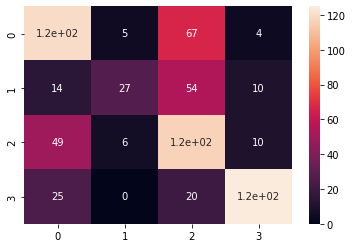

<Figure size 1440x360 with 0 Axes>

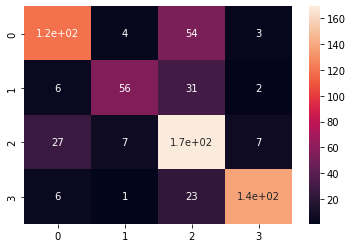

<Figure size 1440x360 with 0 Axes>

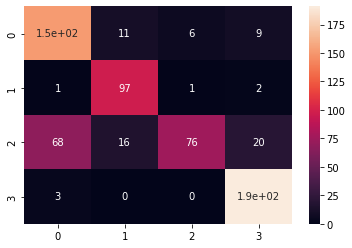

<Figure size 1440x360 with 0 Axes>

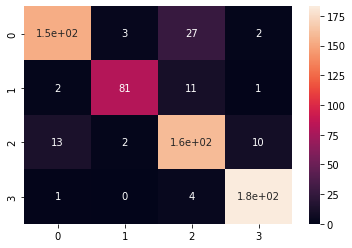

<Figure size 1440x360 with 0 Axes>

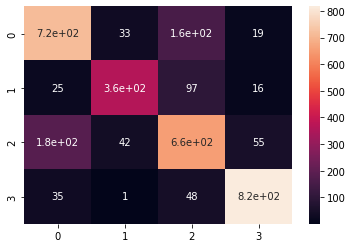

In [21]:
from sklearn.model_selection import KFold
model_path = 'models/k_fold/mycnn/'
cfs_inception = []
X = np.load('data/X.npy')
y = np.load('data/Y.npy')
X_flatten = np.load('data/X_flatten.npy')

kfold = KFold(n_splits=5, random_state=1, shuffle=True)
kfold.get_n_splits(X)
model_inception = createModelMyCNN()
inception_scores = []
i = 1
for train_index, test_index in kfold.split(X):
    
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path + 'checkpoints',
            save_weights_only=False,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)

  history = model_inception.fit(X_train, y_train,
                      epochs=2,
                      callbacks=[model_checkpoint_callback],
                      batch_size=64,
                      validation_data=(X_test, y_test),
                      verbose=1)

  plt.figure(figsize=(20, 5))

  plt.subplot(1, 2, 1)
  sns.lineplot(x=history.epoch,
                y=history.history['loss'], color='red', label='Loss')
  sns.lineplot(x=history.epoch,
                y=history.history['val_loss'], color='orange', label='Val Loss')
  plt.title('Loss on train vs test')
  plt.legend(loc='best')

  plt.subplot(1, 2, 2)
  sns.lineplot(x=history.epoch,
                y=history.history['accuracy'], color='blue', label='Accuracy')
  sns.lineplot(x=history.epoch,
                y=history.history['val_accuracy'], color='green', label='Val Accuracy')
  plt.title('Accuracy on train vs test')
  plt.legend(loc='best')

  plt.savefig('figures/k_fold/mycnn_acc_loss_graph_fold_'+str(i)+'.png')
  plt.clf()

  y_pred = model_inception.predict(X_test)

  create_roc_curve(y_test, y_pred, "mycnn", i)

  y_test = np.argmax(y_test, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  conf_matr = confusion_matrix(y_test, y_pred)

  FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
  FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
  TP = np.diag(conf_matr)
  TN = conf_matr.sum() - (FP + FN + TP)

  acc = (TP + TN) / (TP + FP + FN + TN)
  sen = TP / (TP + FN)
  pre = TP / (TP + FP)
  spe = TN / (TN + FP)
  f1 = (2 * (pre * sen)) / (pre + sen)

  inception_scores.append([(i), np.mean(acc), np.mean(sen),
                                         np.mean(pre), np.mean(f1), np.mean(spe)])
  plt.clf()
  cfs_inception.append(conf_matr)
  sns.heatmap(conf_matr, annot=True)
  plt.savefig('figures/k_fold/mycnn_conf_matrix_graph_'+str(i)+'.png')
  i+=1

plt.clf()

np.save('mycnn_cfs.npy', np.array(cfs_inception))
overlapped_matrix_inception = np.array(cfs_inception).sum(axis=0)
sns.heatmap(overlapped_matrix_inception, annot=True)
plt.savefig('figures/k_fold/mycnn_overlapped_matrix_graph.png')
df_inception = pd.DataFrame(inception_scores, columns=['fold_number', 'acc', 'sen', 'pre', 'f1', 'spe'])

df_inception.to_csv('scores/k_fold/mycnn_scores.csv')
model_inception.save(model_path + 'model.h5')

# KNN için 5 Foldluk Eğitim

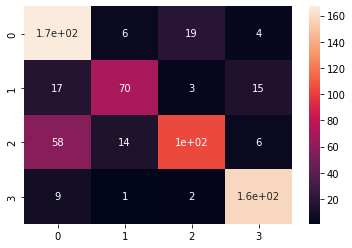

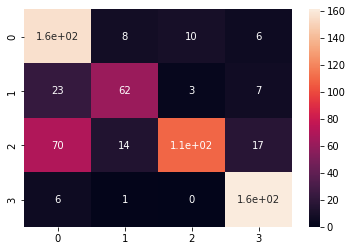

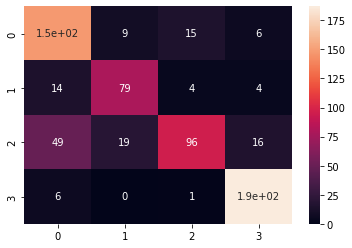

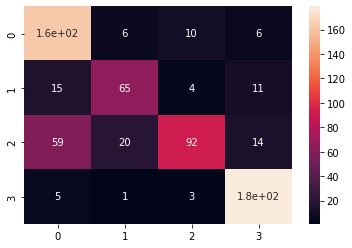

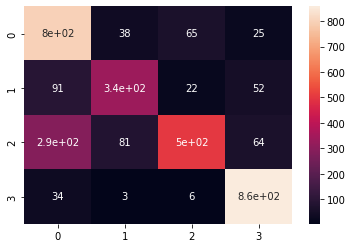

In [8]:
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import KFold
model_path = 'models/k_fold/mycnn/'

cfs_inception = []
X = np.load('data/X.npy')
y = np.load('data/Y.npy')
X_flatten = np.load('data/X_flatten.npy')

model = KNeighborsClassifier()

kfold = KFold(n_splits=5, random_state=1, shuffle=True)
kfold.get_n_splits(X_flatten)

inception_scores = []
scores = []
i = 1
for train_index, test_index in kfold.split(X_flatten):
    
  X_train, X_test = X_flatten[train_index], X_flatten[test_index]
  y_train, y_test = y[train_index], y[test_index]



  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  create_roc_curve(y_test, y_pred, 'knn', i)

  y_test = np.argmax(y_test, axis=1)
  y_pred = np.argmax(y_pred, axis=1)

  conf_matr = confusion_matrix(y_test, y_pred)

  FP = conf_matr.sum(axis=0) - np.diag(conf_matr)
  FN = conf_matr.sum(axis=1) - np.diag(conf_matr)
  TP = np.diag(conf_matr)
  TN = conf_matr.sum() - (FP + FN + TP)

  acc = (TP + TN) / (TP + FP + FN + TN)
  sen = TP / (TP + FN)
  pre = TP / (TP + FP)
  spe = TN / (TN + FP)
  f1 = (2 * (pre * sen)) / (pre + sen)

  cfs_inception.append(conf_matr)
  sns.heatmap(conf_matr, annot=True)
  plt.savefig('figures/k_fold/knn_conf_graph_'+str(i)+'.png')


  
  scores.append([(i), np.mean(acc), np.mean(sen),
                                         np.mean(pre), np.mean(f1), np.mean(spe)])

  i+=1


plt.clf()
overlapped_matrix_inception = np.array(cfs_inception).sum(axis=0)
sns.heatmap(overlapped_matrix_inception, annot=True)
plt.savefig('figures/k_fold/knn_overlapped_matrix_graph.png')

df = pd.DataFrame(scores, columns=['fold_number','acc', 'sen', 'pre', 'f1', 'spe'])
df.to_csv('scores/k_fold/knn_scores.csv')